In [1]:
%matplotlib inline
from cgcglib import *
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14, 6]

ImportError: No module named cgcglib

In [20]:
def data_generator():
    """Some example initial-boundary data and right-hand side for testing"""
    data = {}
    d = 5  # Degree for form representation
    # Data 1: An exponential peak following a sinusoid path
    u0 = Expression("exp(-pow(x[1]-1.0, 2.0))", degree=d)
    u1 = Expression("0.0", degree=d)
    u_bc = Expression("exp(-pow(x[1]-cos(x[0]), 2.0))", degree=d)
    f = Expression("-2.0*cos(x[0])*exp(-pow(x[1]-cos(x[0]),2.0))"
                   "*(2.0*pow(cos(x[0]),3.0)-4.0*x[1]*pow(cos(x[0]),2.0)"
                   "+2.0*x[1]*x[1]*cos(x[0])-2.0*cos(x[0])+x[1])", degree=d)
    data["moving_peak"] = (u0, u1, u_bc, f)
    # Data 2: Plucking a string in the middle
    u0 = Expression("exp(- x[1] * x[1] * 50)", degree=d)
    u1 = Expression("0.0", degree=d)
    u_bc = Constant(0.0)
    f = Expression("0.0", degree=d)
    data["plucked_string"] = (u0, u1, u_bc, f)
    # Data 3: Standing wave
    k = 0.0
    w = 3.0
    u0 = Expression("sin(k*pi/5.0*x[1])", degree=d, k=k, w=w)
    u1 = Expression("0.0", degree=d)
    u_bc = Constant(0.0)
    f = Expression("(k*k*pi*pi/25.0-w*w)*sin(k*pi/5.0*x[1])*cos(w*x[0])", degree=d, k=k, w=w)
    data["standing_wave"] = (u0, u1, u_bc, f)
    return data
data = data_generator()

In [34]:
def test_mesh_generator(T, mesh_generator, nx=50, data=data["moving_peak"], file_prefix=None):
    """Solving the CG-CG wave equation on the mesh produced by mesh_generator.
    
    Args:
        T: Terminal time.
        mesh_generator: a function which generates the mesh from (domain, nt, nx)
        nx: number of nodes in the spatial direction
        data: a quadruple (u0, u1, u_bc, f) as the initial, boundary, and right-hand side
        file_prefix: A string if not None. The numerical solution is saved as file_prefix+".pvd".
    
    While nx is specified by the user. nt, the number of nodes per temporal direction, 
    is always chosen so that for the uniforma mesh, dt/dx=0.5 (CFL safe).
    """
    # Space-time domain
    domain = SpaceTimeDomain(t0=0, t1=T, x0=-5.0, x1=5.0)
    # Mesh for show
    mesh = mesh_generator(domain, 50, 5)
    plt.figure()
    plot(mesh)
    plt.title("Mesh (down sampled for plotting)")
    # Computational mesh for solving PDE
    nt = int(T / (domain.x1 - domain.x0)) * nx * 2  # dt/dx=0.5 for the unperturbed case 
    mesh = mesh_generator(domain, nt, nx)
    # Solve
    uh = solve_wave_equation(*data, domain=domain, mesh=mesh, degree=1)
    if file_prefix:
        File(file_prefix + ".pvd") << uh
    # Plot the solution
    plt.figure()
    plot(uh)
    plt.title("Numerical solution")
    # Plot the L2 norm in time
    plt.figure()
    ts = np.linspace(domain.t0, domain.t1, 200)
    xs = np.linspace(domain.x0, domain.x1, 100)
    u_vals = np.vectorize(uh)(*np.meshgrid(ts, xs))
    plt.plot(ts, np.linalg.norm(u_vals, axis=0))
    plt.xlabel("Time")
    plt.ylabel("Spatial L2 norm")
    plt.title("Sptial L2 norm in time")

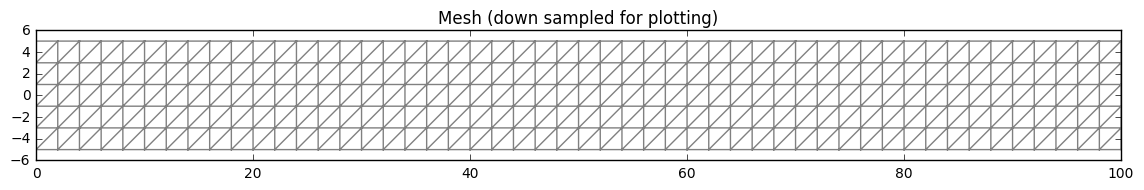

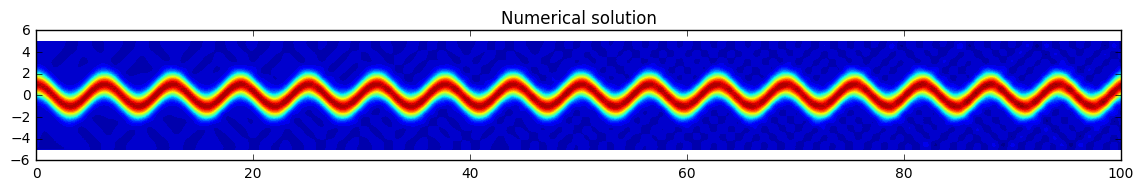

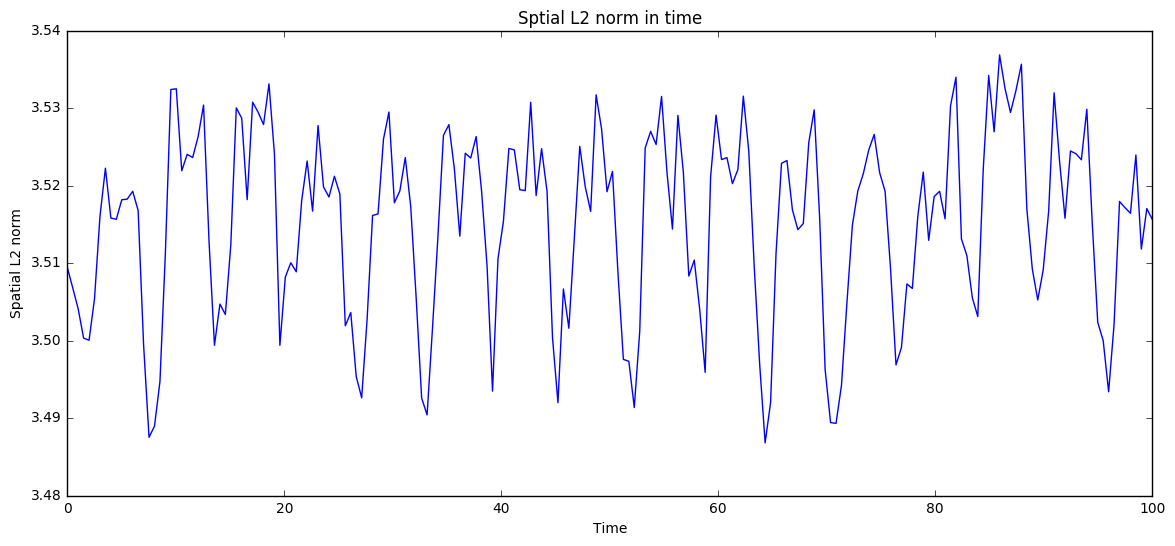

In [35]:
# Uniform mesh (no problem)
def mesh_gen(domain, nt, nx):
    return domain.get_uniform_mesh(nt, nx)
test_mesh_generator(100, mesh_gen)

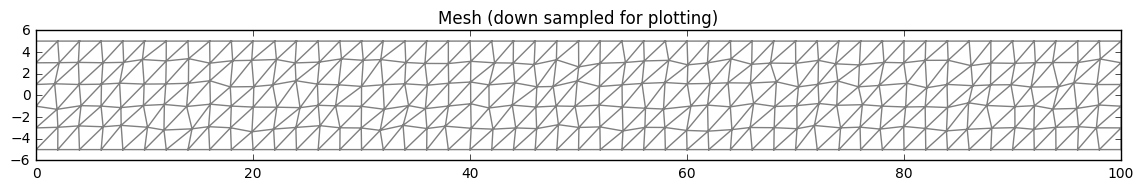

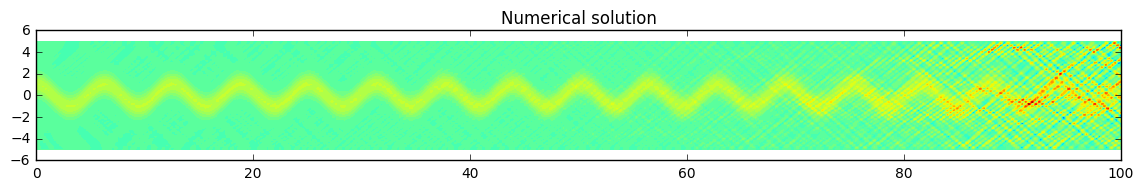

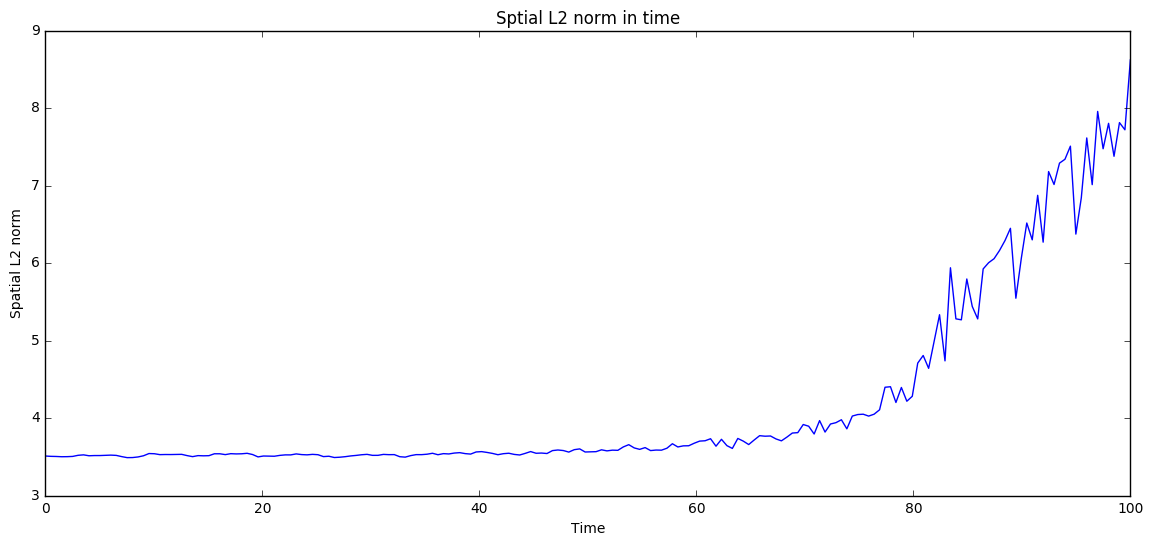

In [58]:
# Randomized mesh
def randomly_perturbed_mesh(percentage=0.0):
    """Randomly perturbed every non-boundary mesh node by a percentage of the mesh size."""
    def mesh_gen(domain, nt, nx):
        mesh = domain.get_uniform_mesh(nt, nx)
        mesh = mesh_randomizer_2d(mesh, percentage=percentage, preserve_boundary=True)
        return mesh
    return mesh_gen
test_mesh_generator(100, randomly_perturbed_mesh(0.14), file_prefix="random")

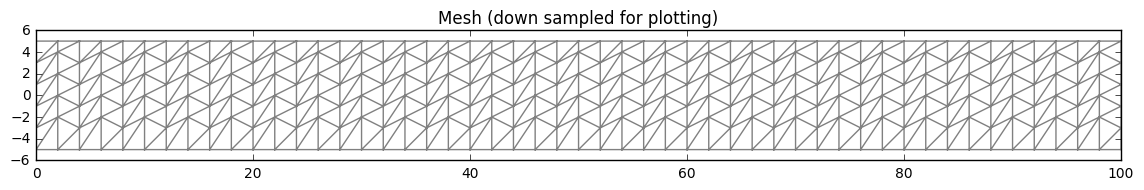

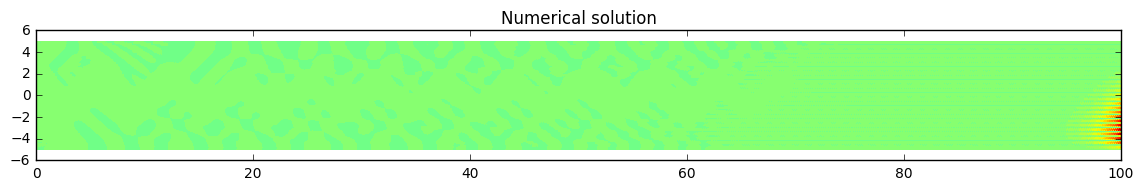

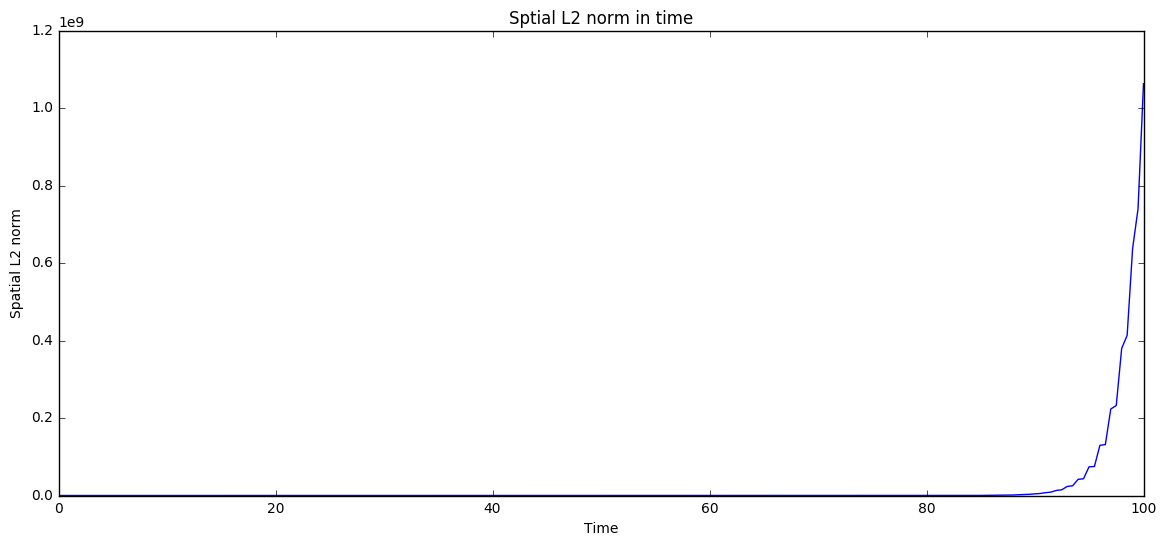

In [113]:
# Structured deterministic perturbation
# In this example, nodes are perturbed spatially every 2 spatial layers.
# From the von Neumann analysis, the magnification in one layer can be cancelled by the magnification
# in the next layer. So the overall effect is small.
# 
#     Perturbation   effect
#     [0, 0.25]      no visible effect
#     [0.25, 0.5]    still stable for long time with visible artifacts
#     [0.5, 1)       unstable
#
# In particular, the critical value 0.5 is CFL-like, in the sense that the method is fine below it but
# blows up rapidly above it. 
def gapped_perturbation(pt, px):
    def mesh_gen(domain, nt, nx):
        mesh = domain.get_uniform_mesh(nt, nx)
        x_shift = (domain.x1 - domain.x0) / nx * px
        t_shift = (domain.t1 - domain.t0) / nt * pt
        for i in range(1, nt):
            for j in range(1, nx):
                k = i + j * (nt + 1)
                if i % 2 == 1:
                    mesh.coordinates()[k] += np.array([t_shift, x_shift])
        return mesh
    return mesh_gen
test_mesh_generator(100, gapped_perturbation(0.0, 0.501))

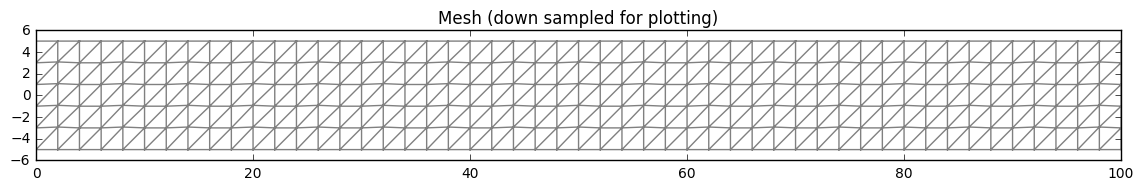

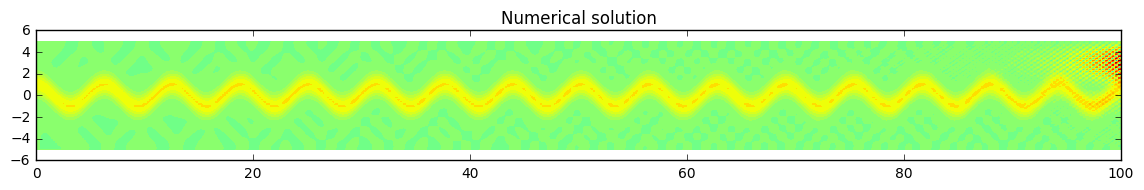

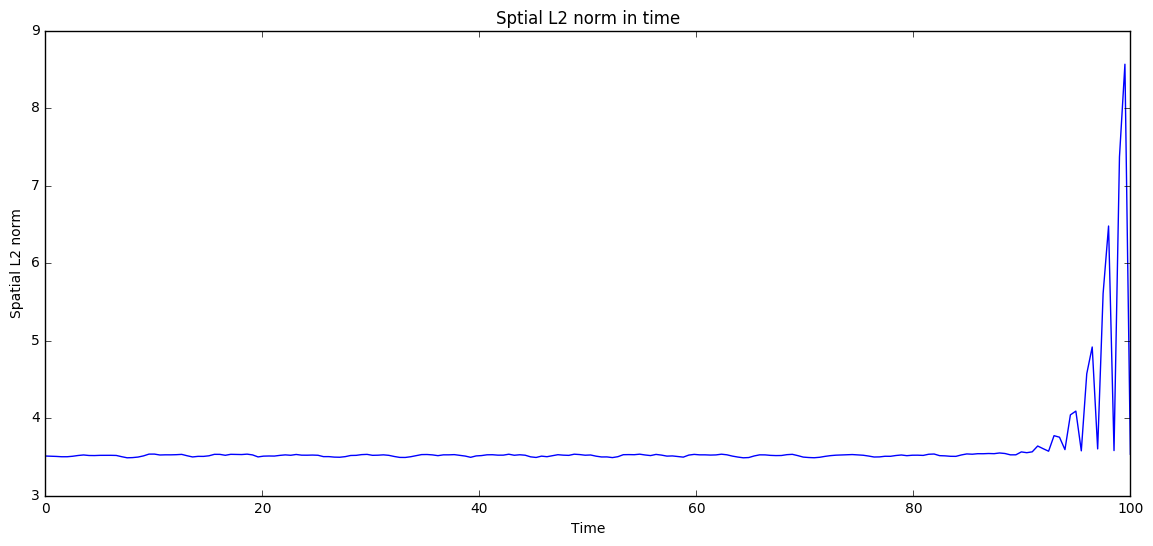

In [115]:
# Structured deterministic perturbation (gapped)
# In this example, nodes are perturbed spatially every 3 spatial layers.
# Becaues the perturbations are slightly further apart than the every other layer case, 
# the effect of the perturbation is much stronger.
#
# The blow up time depends quite smoothly on the perturbation, in contrast with the previous
# case.
#
#     Perturbation   T to observe it (rough)
#     4%             100
#     3%             130
#     2%             200
#     1%             400
#
# My conjecture is that the method is unstable for any nonzero perturbation of this structre. 
# This might be provable using the von Neumann analysis.
#
def gapped_perturbation(pt, px):
    def mesh_gen(domain, nt, nx):
        mesh = domain.get_uniform_mesh(nt, nx)
        x_shift = (domain.x1 - domain.x0) / nx * px
        t_shift = (domain.t1 - domain.t0) / nt * pt
        for i in range(1, nt):
            for j in range(1, nx):
                k = i + j * (nt + 1)
                if i % 3 == 1:
                    mesh.coordinates()[k] += np.array([t_shift, x_shift])
        return mesh
    return mesh_gen
test_mesh_generator(100, gapped_perturbation(0.0, 0.04))